In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss
import pmdarima as pm
import matplotlib.pyplot as plt

In [63]:
df = pd.read_excel("food production.xlsx",sheet_name="Sheet1")
df.head()

,Year,State / Union Territory,Rice,Wheat,Coarse cereals,Pulses,Foodgrains,Oilseeds,Cotton,Sugarcane,Raw Jute & Mesta
0,2022-23,Andhra Pradesh,8542.310000,0.0,2753.460,993.380,12289.150000,616.120,1578.920000,3121.520,11.280000
1,2021-22,Andhra Pradesh,7763.633000,0.0,2258.409,1054.475,11076.517000,548.943,1707.623529,3645.414,10.988889
2,2020-21,Andhra Pradesh,7882.857500,0.0,2321.569,1094.613,11299.039500,804.599,1600.552941,4138.640,10.444444
3,2019-20,Andhra Pradesh,8658.884988,0.0,2531.173,1166.721,12356.778988,901.167,2508.000000,6723.996,21.311111
4,2018-19,Andhra Pradesh,8234.666667,0.0,1864.546,739.593,10838.805667,504.412,1491.000000,8094.618,30.333333


In [ ]:
df['Year'] = df['Year'].apply(lambda x: int(str(x)[:4]))  #fiscal year to calendar year

In [65]:
df.head(2)

,Year,State / Union Territory,Rice,Wheat,Coarse cereals,Pulses,Foodgrains,Oilseeds,Cotton,Sugarcane,Raw Jute & Mesta
0,2022,Andhra Pradesh,8542.310,0.0,2753.460,993.380,12289.150,616.120,1578.920000,3121.520,11.280000
1,2021,Andhra Pradesh,7763.633,0.0,2258.409,1054.475,11076.517,548.943,1707.623529,3645.414,10.988889


In [67]:
df['Year'] = pd.to_datetime(df['Year'],format='%Y')

In [68]:
df = df.sort_values(by=['Year','State / Union Territory'])

In [69]:
df.set_index('Year',inplace=True)

In [70]:
df.head(3)

,State / Union Territory,Rice,Wheat,Coarse cereals,Pulses,Foodgrains,Oilseeds,Cotton,Sugarcane,Raw Jute & Mesta
Year,,,,,,,,,,
1980-01-01,Andhra Pradesh,7011.4,5.9,2559.9,414.5,9991.7,928.1,750.0,10053.9,676.3
1980-01-01,Arunachal Pradesh,88.2,3.8,39.0,0.0,131.0,6.1,0.1,0.0,0.0
1980-01-01,Assam,2522.8,118.3,17.5,47.1,2705.7,111.9,2.0,1723.2,961.4


In [ ]:
df.to_excel("food production_cleaned.xlsx")

In [3]:
df = pd.read_excel("food production_cleaned.xlsx")

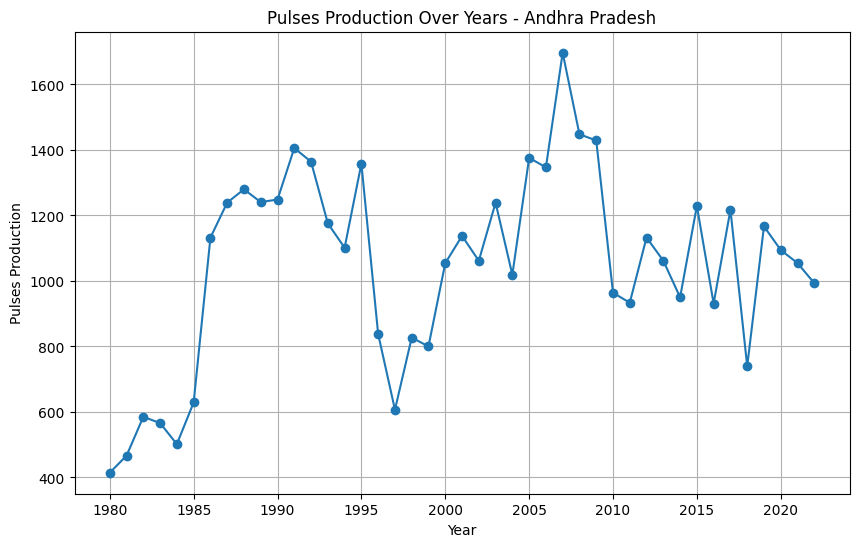

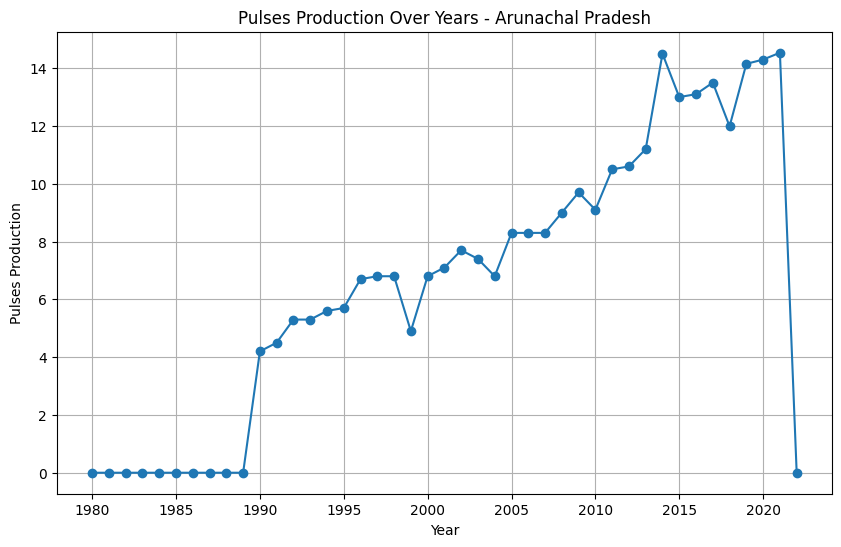

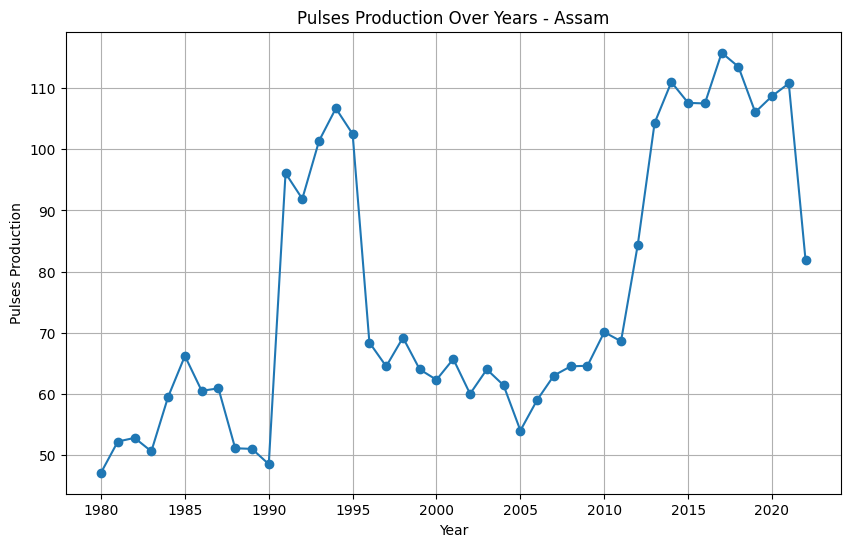

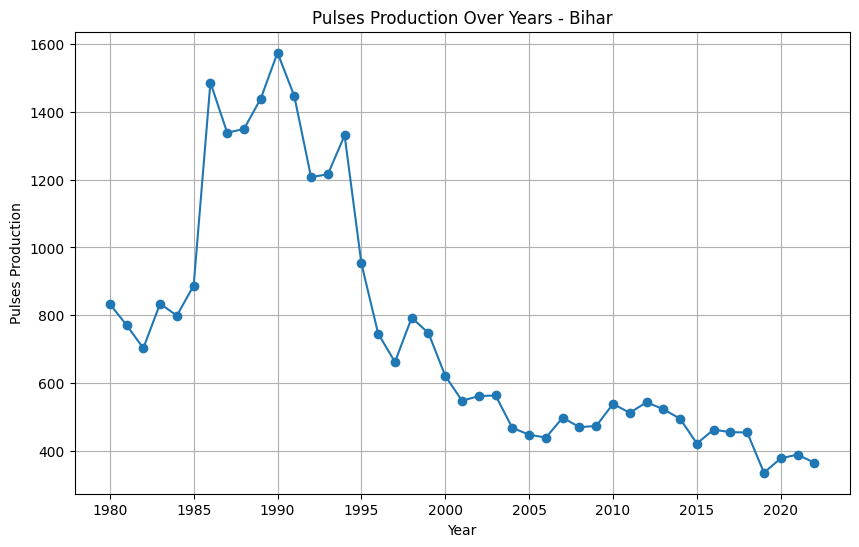

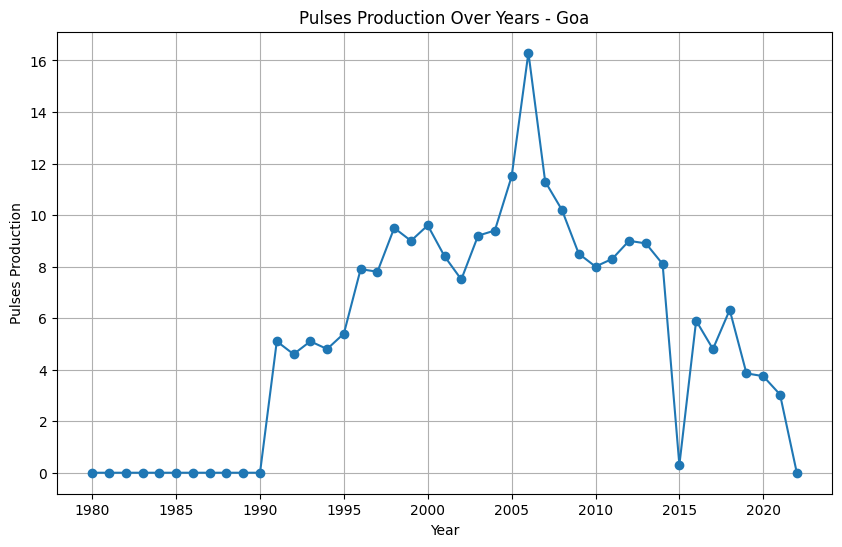

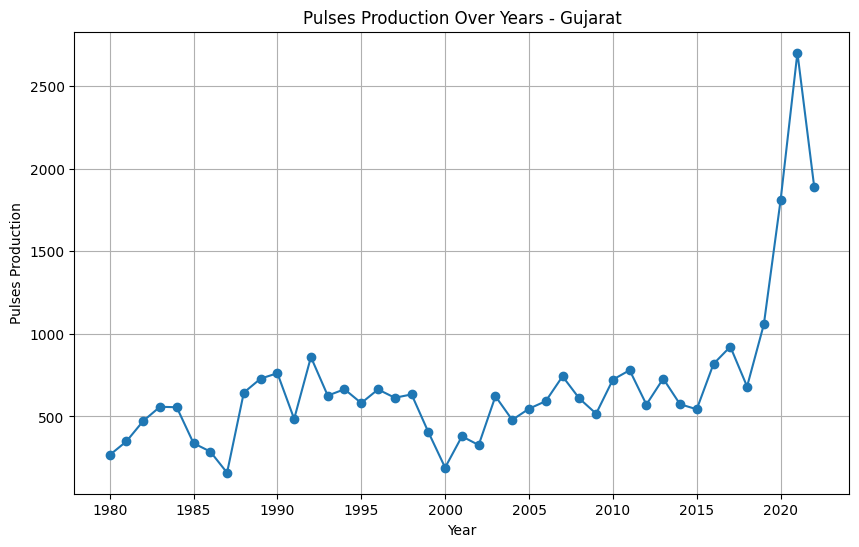

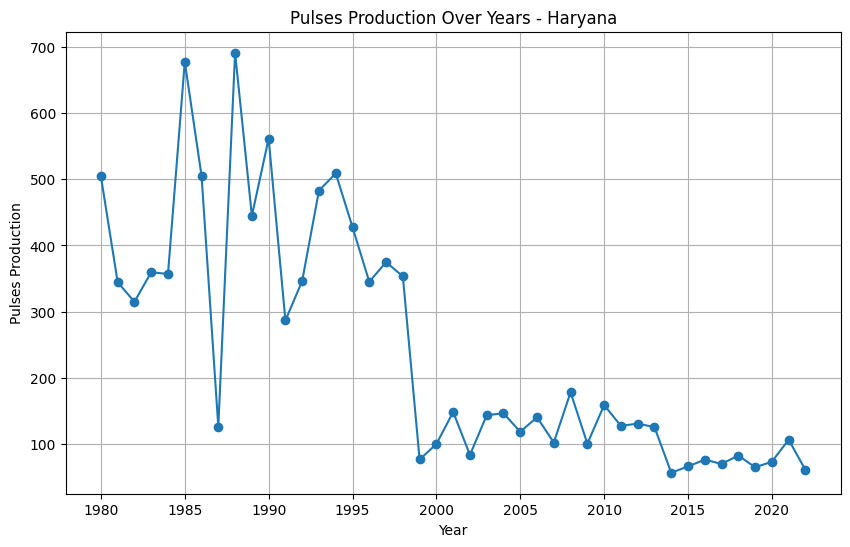

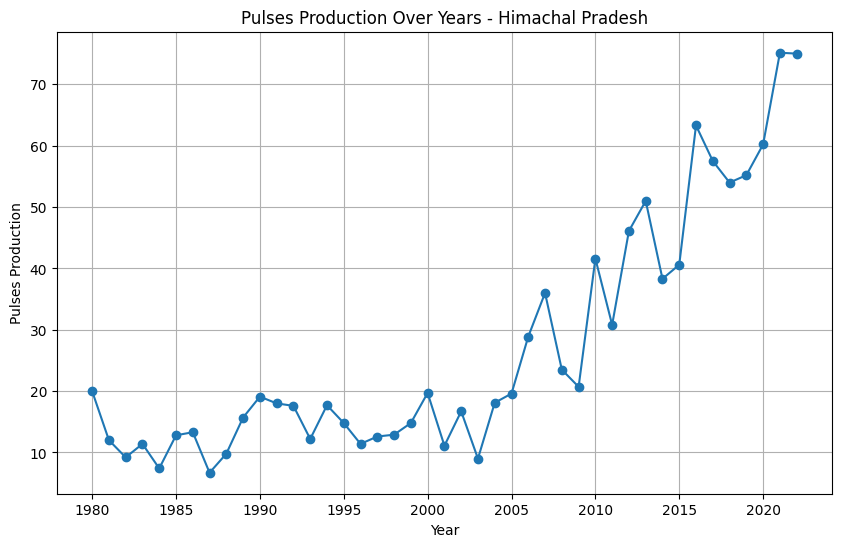

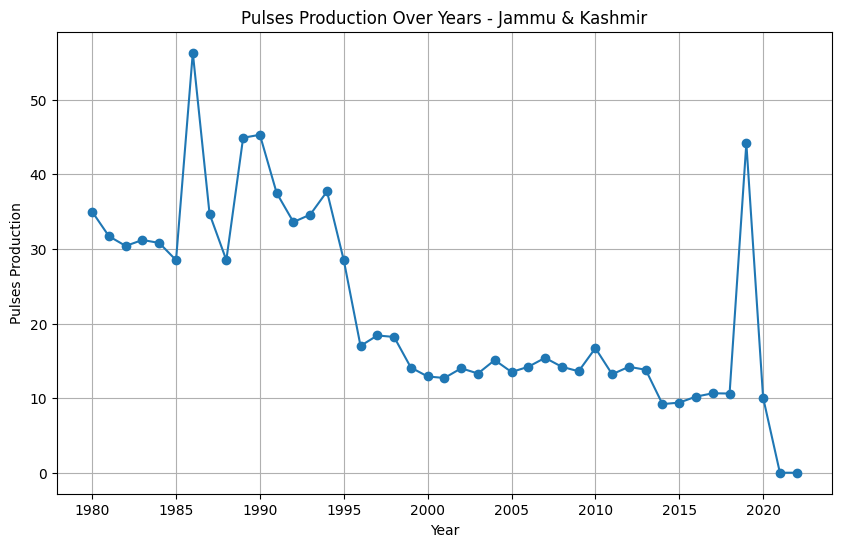

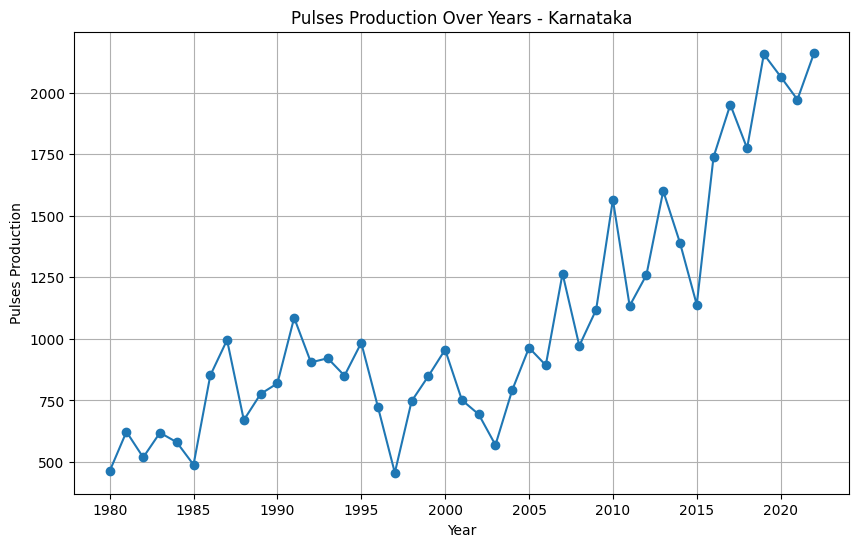

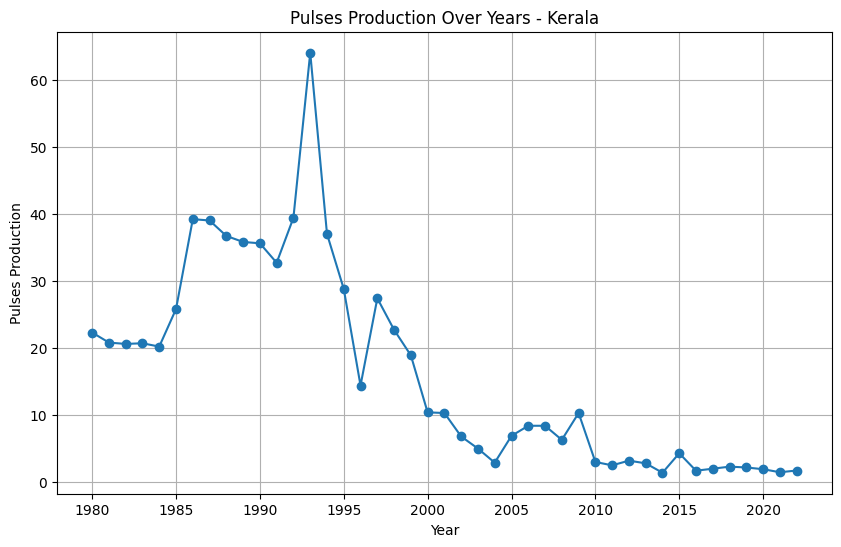

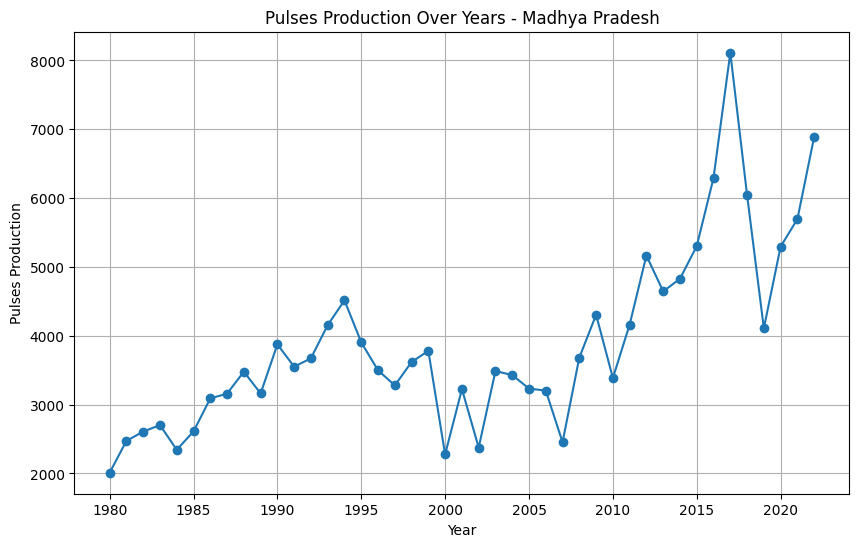

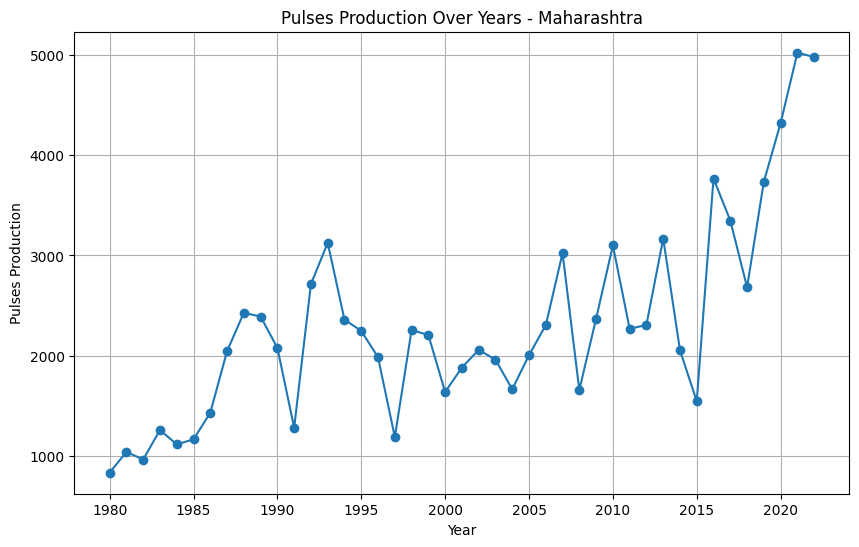

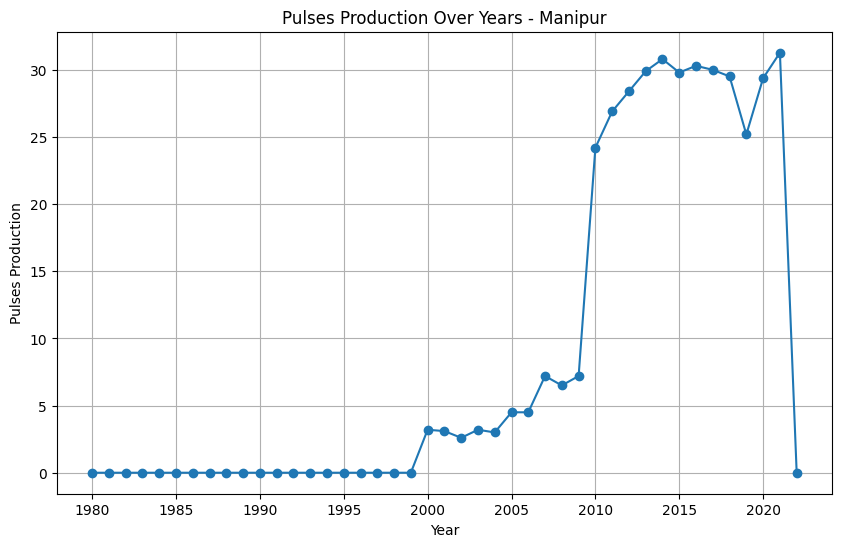

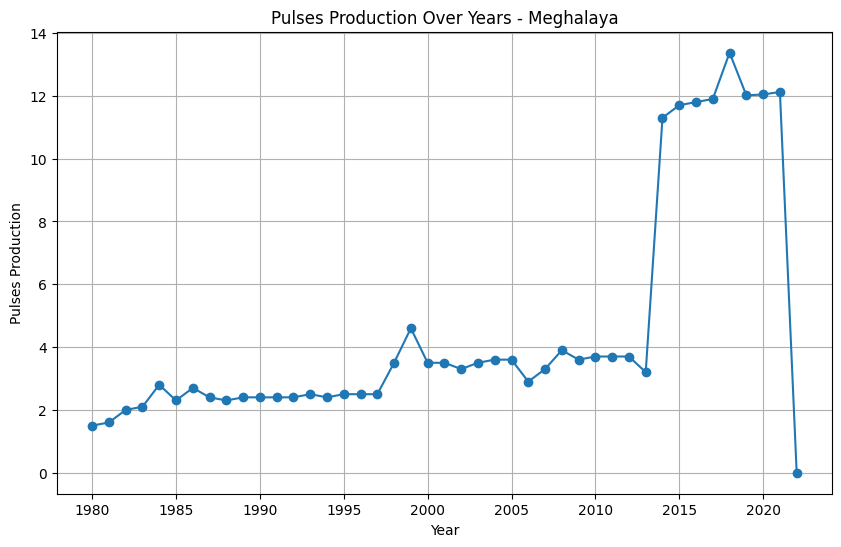

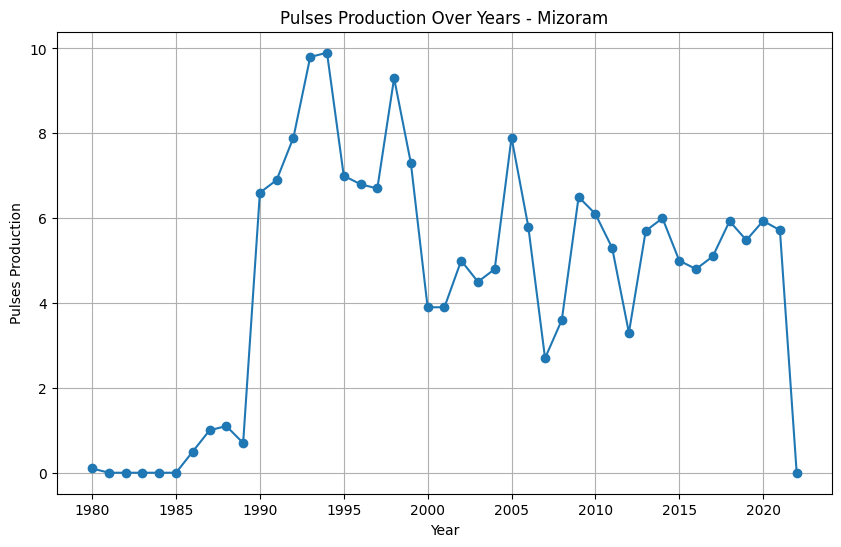

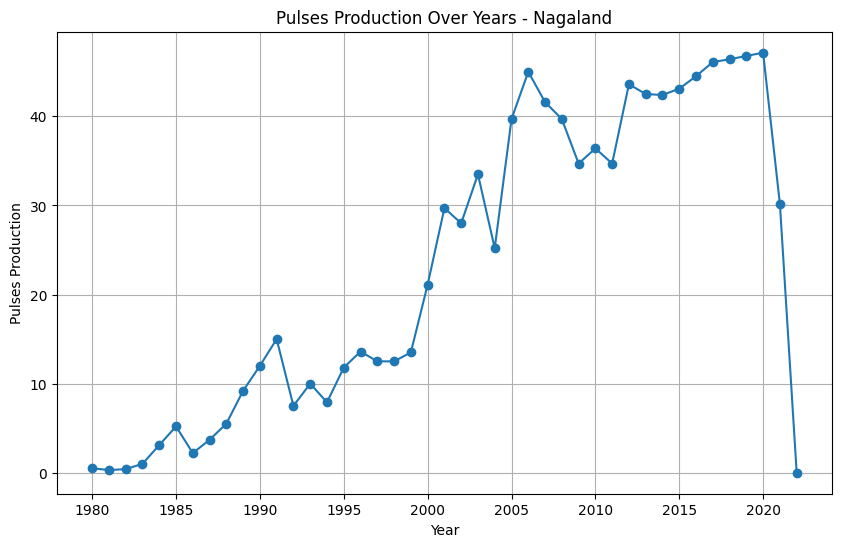

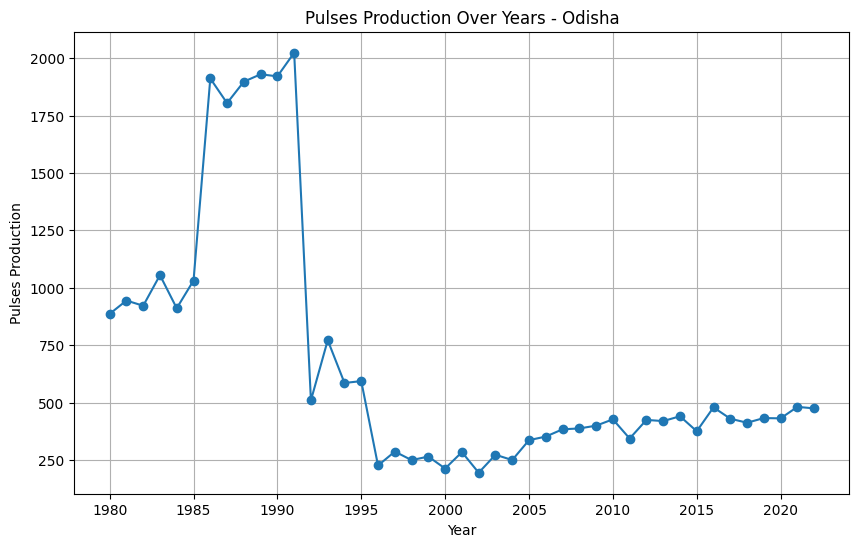

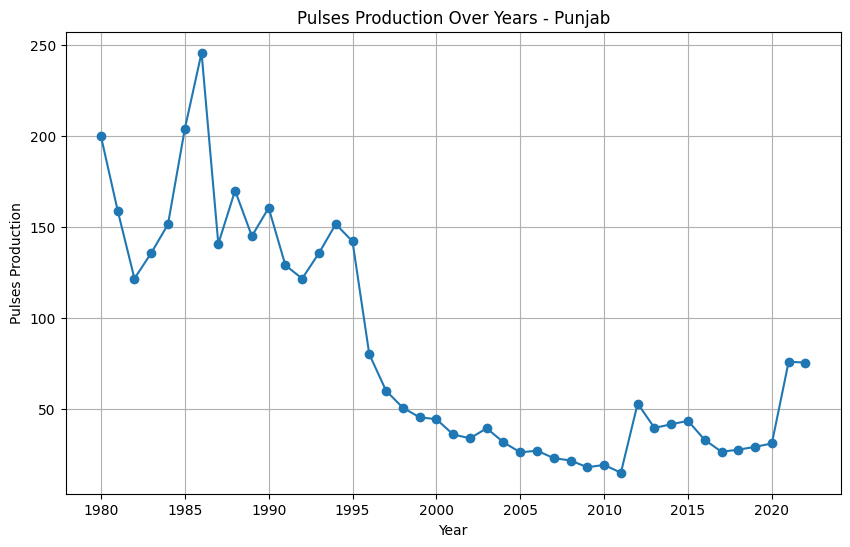

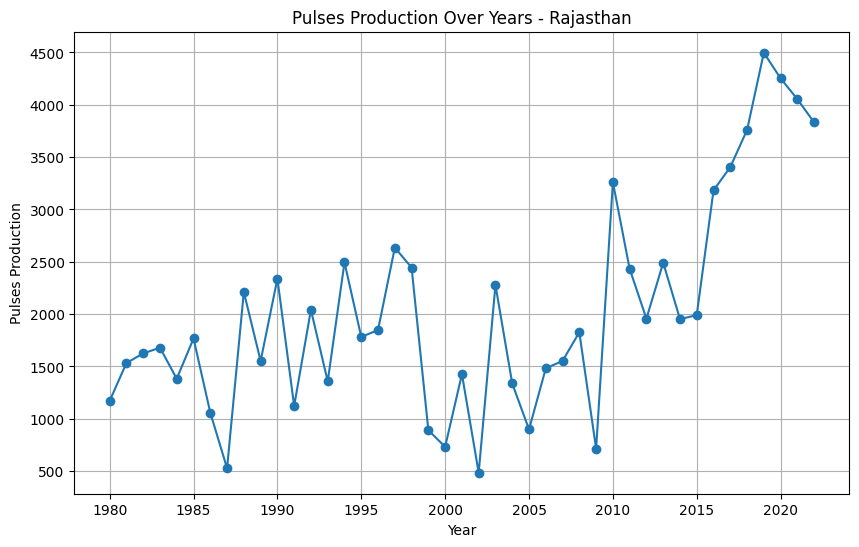

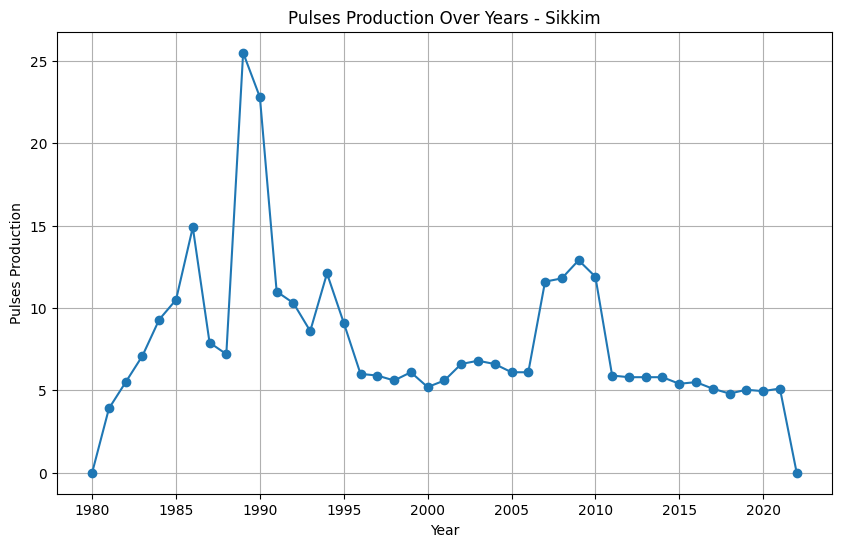

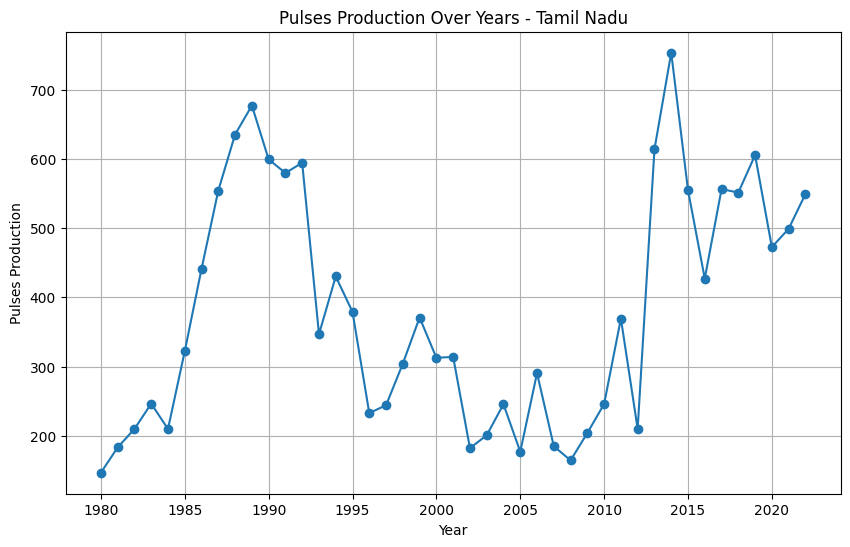

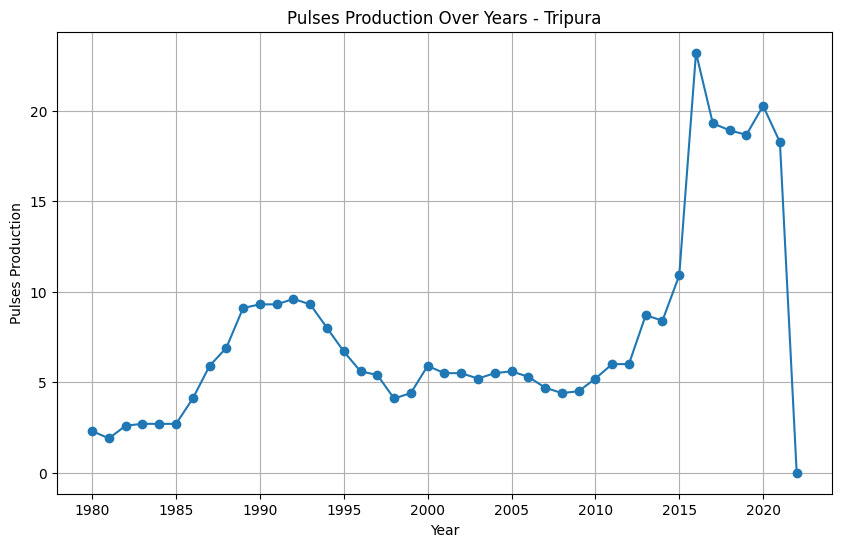

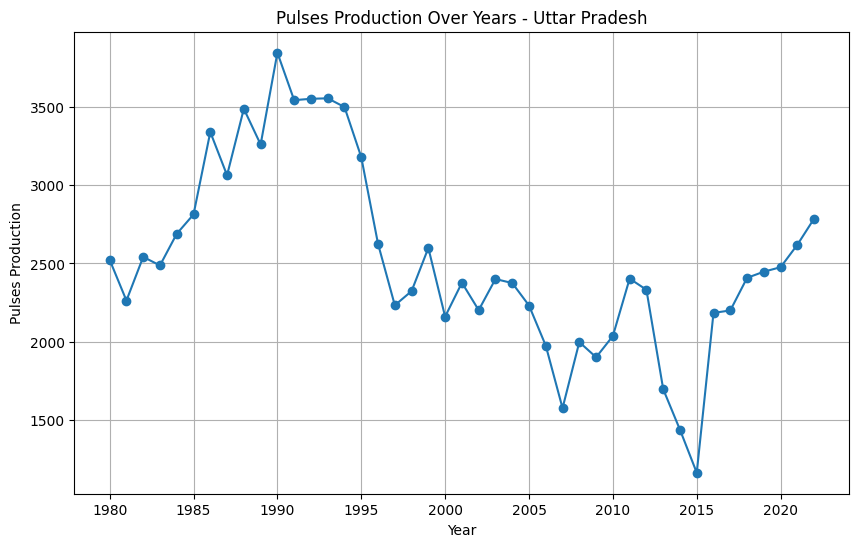

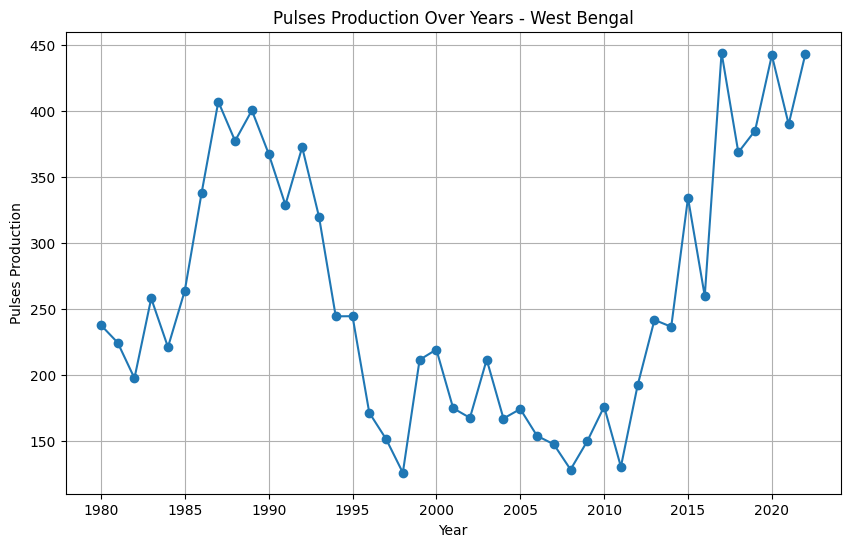

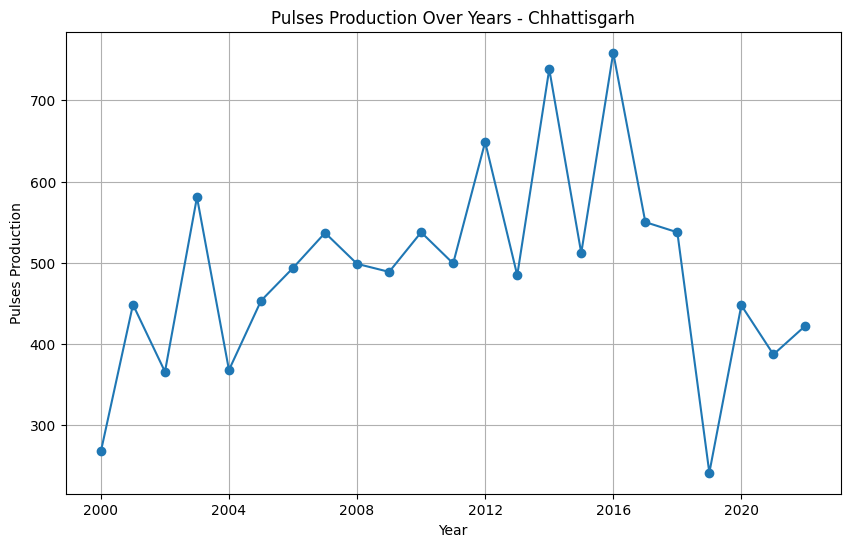

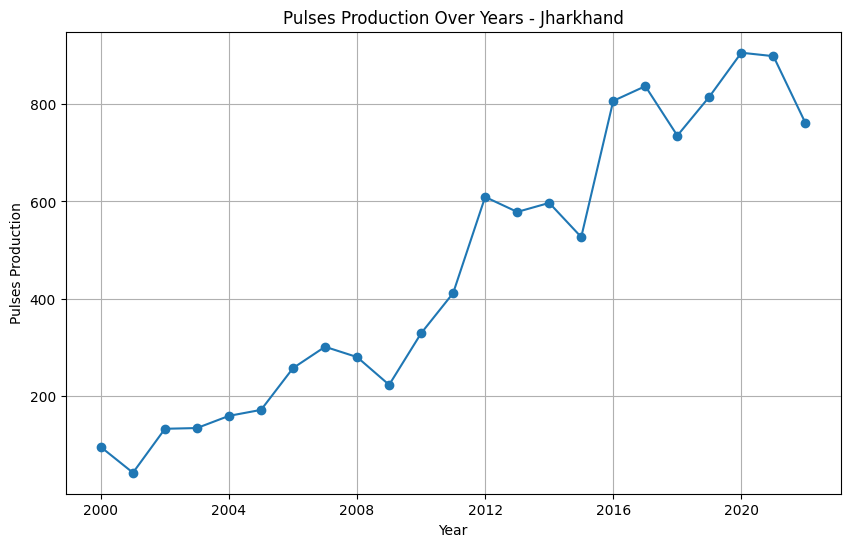

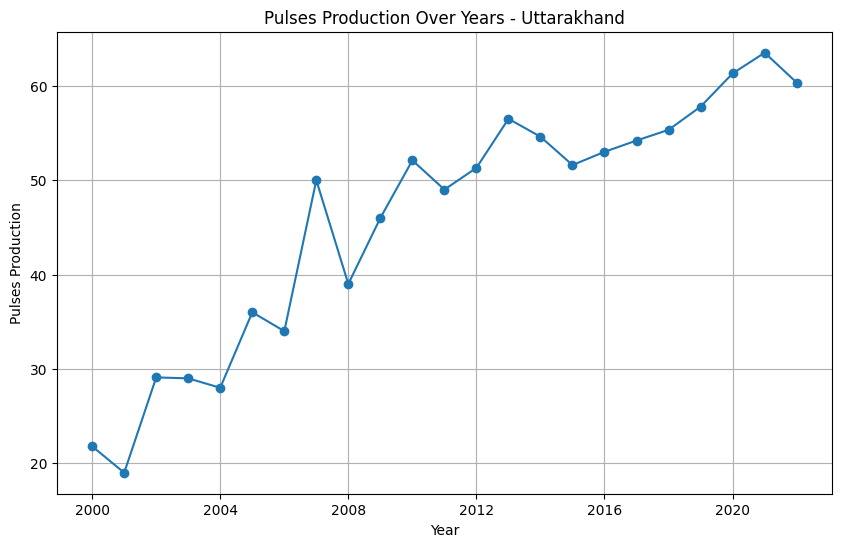

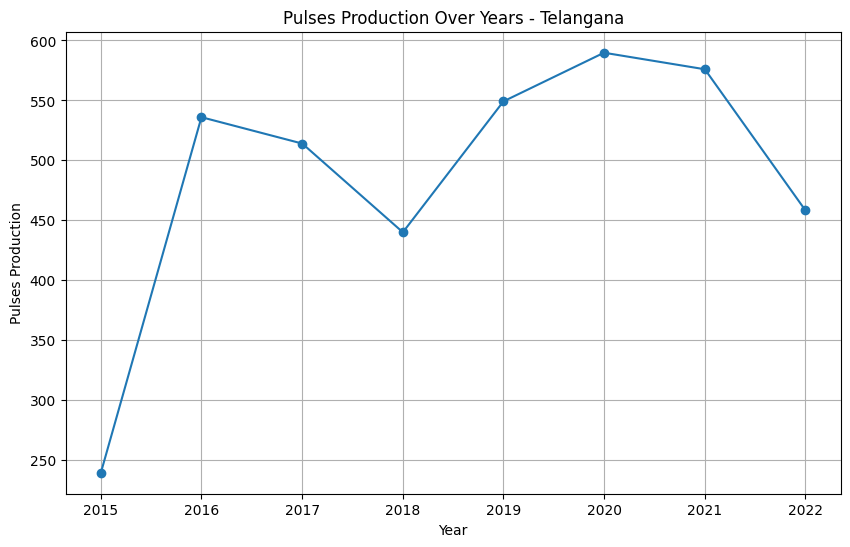

In [ ]:
states = df['State / Union Territory'].unique()
for state in states:
    state_df = df[df['State / Union Territory'] == state]
    plt.figure(figsize=(10, 6))
    plt.title(f"Pulses Production Over Years - {state}")
    plt.plot(state_df['Year'], state_df['Pulses'], marker='o')
    plt.xlabel('Year')
    plt.ylabel('Pulses Production')
    plt.grid(True)
    plt.show()

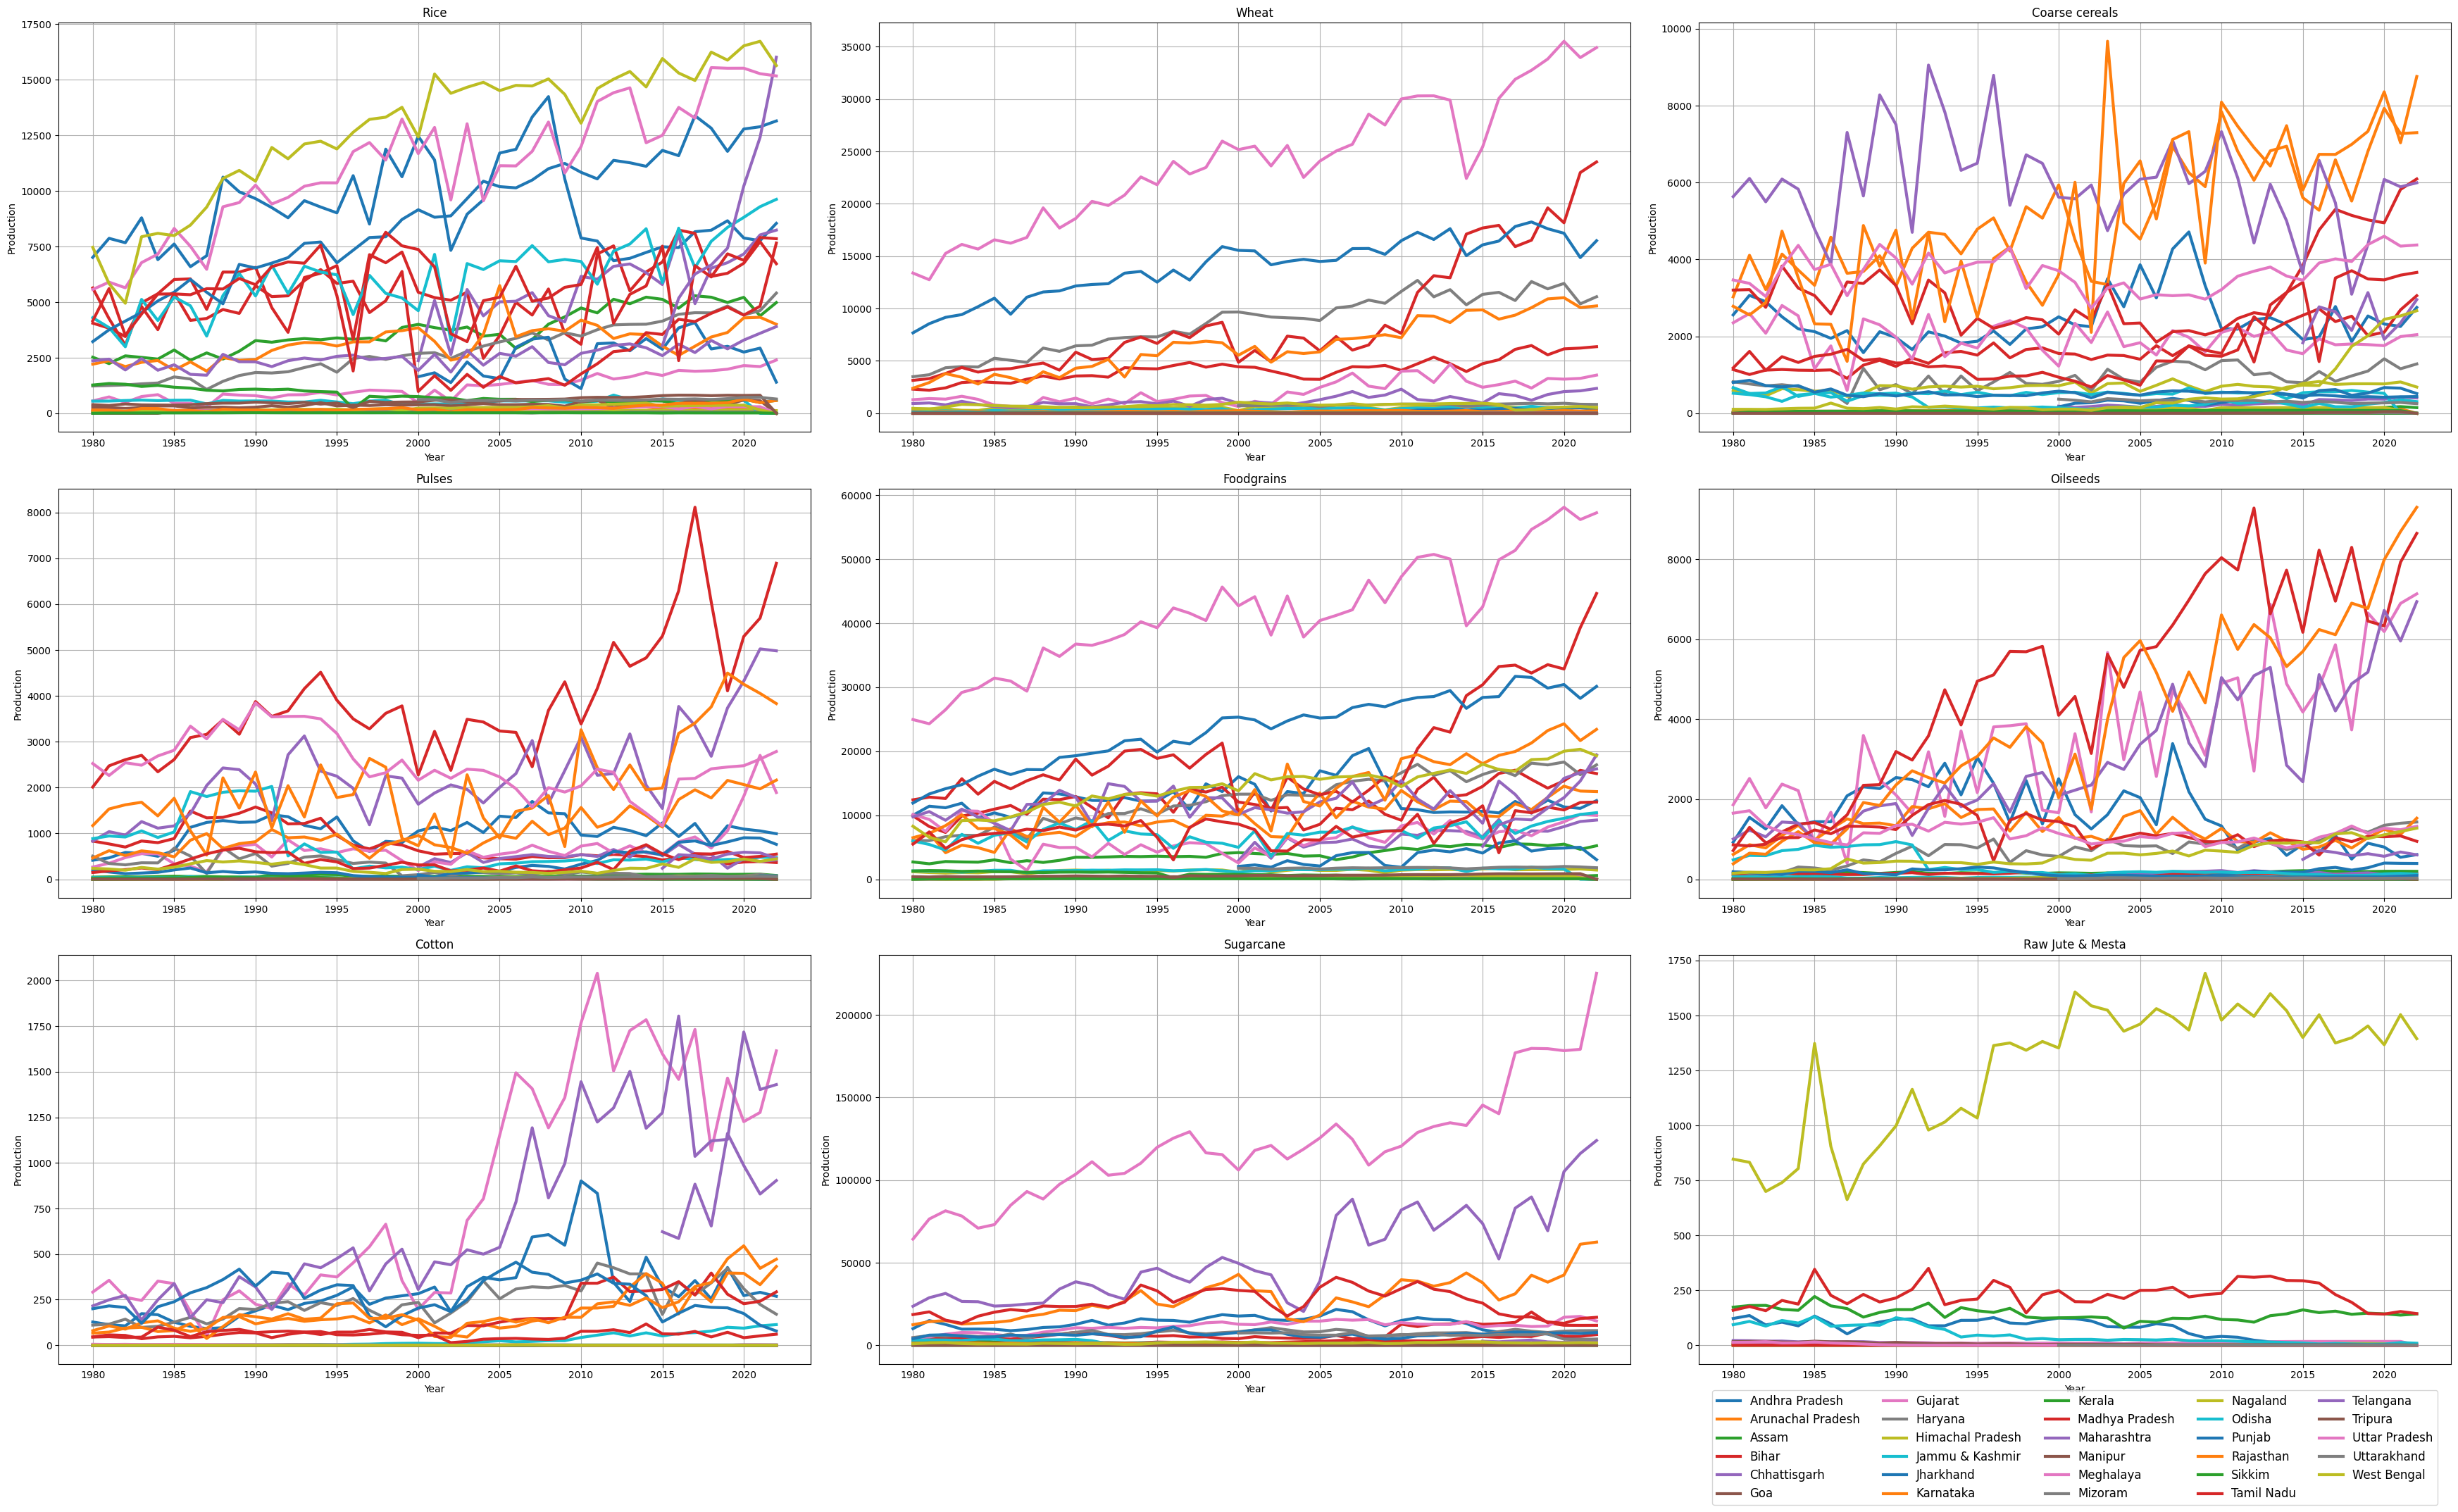

In [ ]:
crop_list = ['Rice', 'Wheat', 'Coarse cereals', 'Pulses', 'Foodgrains', 'Oilseeds', 'Cotton', 'Sugarcane', 'Raw Jute & Mesta']

n_crops = len(crop_list)
nrows = 3
ncols = 3

plt.figure(figsize=(35, 20))

for idx, crop in enumerate(crop_list, 1):
    plt.subplot(nrows, ncols, idx)
    pivot_df = df.pivot(index="Year", columns="State / Union Territory", values=crop)
    for state in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[state], label=state, linewidth=3) #pivot is used to convert our long data into a table where each state’s crop production is a separate line, making it simple to compare trends for all states in one plot per crop
    plt.title(crop)
    plt.xlabel('Year')
    plt.ylabel('Production')
    plt.grid(True)


plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5, fontsize='large')
plt.show()


# exponential smoothing 
## holt's linear method

In [ ]:
#LONG DF
df.rename(columns={'State / Union Territory': 'State'}, inplace=True)
df_long = df.melt(id_vars=['Year', 'State'], var_name='Crop', value_name='Production') #each row represents one crop’s production for a specific state and year, which makes analysis and visualization much easier
df_long['Year'] = pd.to_datetime(df_long['Year']).dt.year

In [9]:
df_long.head(3)

,Year,State,Crop,Production
0,1980,Andhra Pradesh,Rice,7011.4
1,1980,Arunachal Pradesh,Rice,88.2
2,1980,Assam,Rice,2522.8


In [ ]:
forecasts_h = []

for (state, crop), group in df_long.groupby(['State', 'Crop']):
    group = group.sort_values('Year')
    y = group['Production'].values.reshape(-1, 1)

    scaler = StandardScaler() # Scale the data to remove size differences between crops (helps model work better)
    y_scaled = scaler.fit_transform(y).flatten()


    model = ExponentialSmoothing(y_scaled, trend='add', seasonal=None) # Choose Exponential Smoothing model to capture trend over time (no seasonality used)
    fit = model.fit()# Train the model on past production numbers
        
    forecast_scaled = fit.forecast(steps=10)
    forecast_h = scaler.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()# Convert forecast back to original scale so values make sense
        
    for i, val in enumerate(forecast_h, 1):
        forecasts_h.append({'State': state,'Crop': crop,'Year': group['Year'].max() + i,'Forecast_Production': val})

c:\Users\Surbhi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\Surbhi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1380: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
c:\Users\Surbhi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1387: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
c:\Users\Surbhi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1380: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
c:\Users\Surbhi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1387: Runti

In [43]:
h_forecast_df = pd.DataFrame(forecasts_h)
print(h_forecast_df.head())

            State            Crop  Year  Forecast_Production
0  Andhra Pradesh  Coarse cereals  2023          2568.561272
1  Andhra Pradesh  Coarse cereals  2024          2565.442270
2  Andhra Pradesh  Coarse cereals  2025          2562.323268
3  Andhra Pradesh  Coarse cereals  2026          2559.204266
4  Andhra Pradesh  Coarse cereals  2027          2556.085264


# Stationarity check

In [45]:
import warnings
warnings.filterwarnings("ignore")

In [46]:
stationarity_results = {'Stationary': [], 'Non-Stationary': []}
 
for (state, crop), group in df_long.groupby(['State', 'Crop']):
    series = group.sort_values('Year')['Production']

    try:
        stat, p_value, *_ = kpss(series, regression='c', nlags='auto')
        if p_value < 0.05:
            stationarity_results['Non-Stationary'].append((state, crop))
        else:
            stationarity_results['Stationary'].append((state, crop))
    except:
        continue
 
print("Number of stationary series:", len(stationarity_results['Stationary']))
print("Number of non-stationary series:", len(stationarity_results['Non-Stationary']))
print("Stationary series:", stationarity_results['Stationary'])
print("Non-stationary series:", stationarity_results['Non-Stationary'])

Number of stationary series: 69
Number of non-stationary series: 171
Stationary series: [('Andhra Pradesh', 'Coarse cereals'), ('Andhra Pradesh', 'Foodgrains'), ('Andhra Pradesh', 'Pulses'), ('Andhra Pradesh', 'Rice'), ('Andhra Pradesh', 'Sugarcane'), ('Arunachal Pradesh', 'Cotton'), ('Arunachal Pradesh', 'Wheat'), ('Bihar', 'Oilseeds'), ('Bihar', 'Raw Jute & Mesta'), ('Bihar', 'Rice'), ('Chhattisgarh', 'Cotton'), ('Chhattisgarh', 'Oilseeds'), ('Chhattisgarh', 'Pulses'), ('Goa', 'Foodgrains'), ('Goa', 'Oilseeds'), ('Goa', 'Pulses'), ('Goa', 'Rice'), ('Gujarat', 'Coarse cereals'), ('Gujarat', 'Foodgrains'), ('Himachal Pradesh', 'Oilseeds'), ('Himachal Pradesh', 'Sugarcane'), ('Jammu & Kashmir', 'Coarse cereals'), ('Jammu & Kashmir', 'Foodgrains'), ('Jammu & Kashmir', 'Oilseeds'), ('Jammu & Kashmir', 'Rice'), ('Jharkhand', 'Rice'), ('Jharkhand', 'Sugarcane'), ('Karnataka', 'Oilseeds'), ('Madhya Pradesh', 'Coarse cereals'), ('Madhya Pradesh', 'Rice'), ('Maharashtra', 'Coarse cereals'), ('

In [18]:
non_stationary = stationarity_results['Non-Stationary']
stationary = stationarity_results['Stationary']

# AUTO ARIMA

In [ ]:
forecasts = []
model_summaries = []# To store model details (order, AIC score)

for (state, crop), group in df_long.groupby(['State', 'Crop']):
    y = group.sort_values('Year')['Production'].values

    p = 0
    q = 0
    d = 0 if (state, crop) in stationary else 1# If series is stationary, no differencing; else d=1

    model = pm.auto_arima(y,p=p,q=q,max_p=2,max_q=2,d=d,seasonal=False,stepwise=True,suppress_warnings=True,error_action='ignore',trace=False)

    model_summaries.append({'State': state,'Crop': crop,'order': model.order,'AIC': model.aic()})

    forecast_vals = model.forecast(n_periods=10)
    for i, val in enumerate(forecast_vals, 1):
        forecasts.append({'State': state,'Crop': crop,'Year': group['Year'].max() + i,'Forecast_Production': val})

In [20]:
model_summary_df = pd.DataFrame(model_summaries)

In [21]:
forecast_df = pd.DataFrame(forecasts)
print(forecast_df.head())

            State            Crop  Year  Forecast_Production
0  Andhra Pradesh  Coarse cereals  2023          2647.087426
1  Andhra Pradesh  Coarse cereals  2024          2579.578445
2  Andhra Pradesh  Coarse cereals  2025          2536.734107
3  Andhra Pradesh  Coarse cereals  2026          2509.543098
4  Andhra Pradesh  Coarse cereals  2027          2492.286420


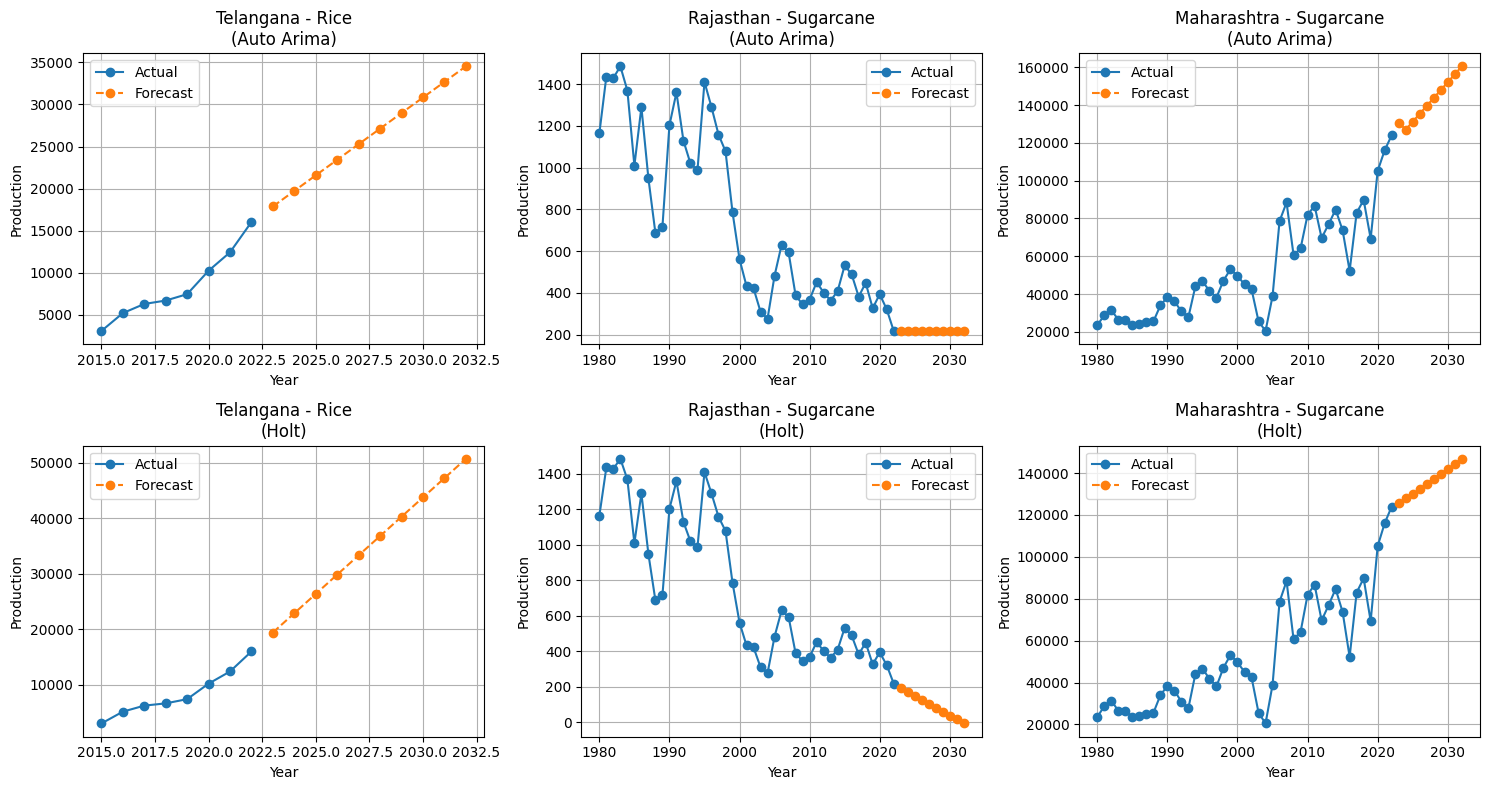

In [ ]:
import matplotlib.pyplot as plt

# Define all combinations
plots = [
    ('Telangana', 'Rice', 'Auto Arima', forecast_df),
    ('Rajasthan', 'Sugarcane', 'Auto Arima', forecast_df),
    ('Maharashtra', 'Sugarcane', 'Auto Arima', forecast_df),
    ('Telangana', 'Rice', 'Holt', h_forecast_df),
    ('Rajasthan', 'Sugarcane', 'Holt', h_forecast_df),
    ('Maharashtra', 'Sugarcane', 'Holt', h_forecast_df)
]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, (state, crop, method, df_forecast) in enumerate(plots):
    ax = axes[i]
    hist = df_long[(df_long['State'] == state) & (df_long['Crop'] == crop)]
    fut = df_forecast[(df_forecast['State'] == state) & (df_forecast['Crop'] == crop)]
    
    ax.plot(hist['Year'], hist['Production'], marker='o', label='Actual')
    ax.plot(fut['Year'], fut['Forecast_Production'], marker='o', linestyle='--', label='Forecast')
    ax.set_title(f"{state} - {crop}\n({method})")
    ax.set_xlabel("Year")
    ax.set_ylabel("Production")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()



# Telangana (Rice):Clear upward trend; ARIMA and Holt give similar strong growth => high confidence.
# Rajasthan (Sugarcane):Declining and noisy; Holt drops too much, ARIMA stabilizes => ARIMA preferred.
# Maharashtra (Sugarcane):Fast growth; both work, ARIMA slightly steeper.

# ARIMA: Best for noisy/unstable data, prevents unrealistic drops.
# Holt: Best for clean, steady linear trends. it overestimates the trends.
# If both models agree, forecast is more reliable.

# All India production

In [26]:
all_india = pd.read_excel('food production.xlsx',sheet_name="all india")
all_india.head(3)

,Year,State / Union Territory,Rice,Wheat,Coarse cereals,Pulses,Foodgrains,Oilseeds,Cotton,Sugarcane,Raw Jute & Mesta
0,2022-23,All India,135542.490000,112742.850000,54752.870000,27504.010000,330542.200000,40996.990000,5839.029100,494228.810000,1709.218800
1,2021-22,All India,129471.418146,107742.070195,51100.650932,27301.691906,315615.831178,37962.982746,5289.990565,439424.893181,1826.808220
2,2020-21,All India,124368.315904,109586.498240,51323.802381,25463.119199,310741.735723,35946.180366,5992.218815,405398.713186,1683.796975


In [27]:
all_india['Year'] = all_india['Year'].apply(lambda x: int(str(x)[:4]))

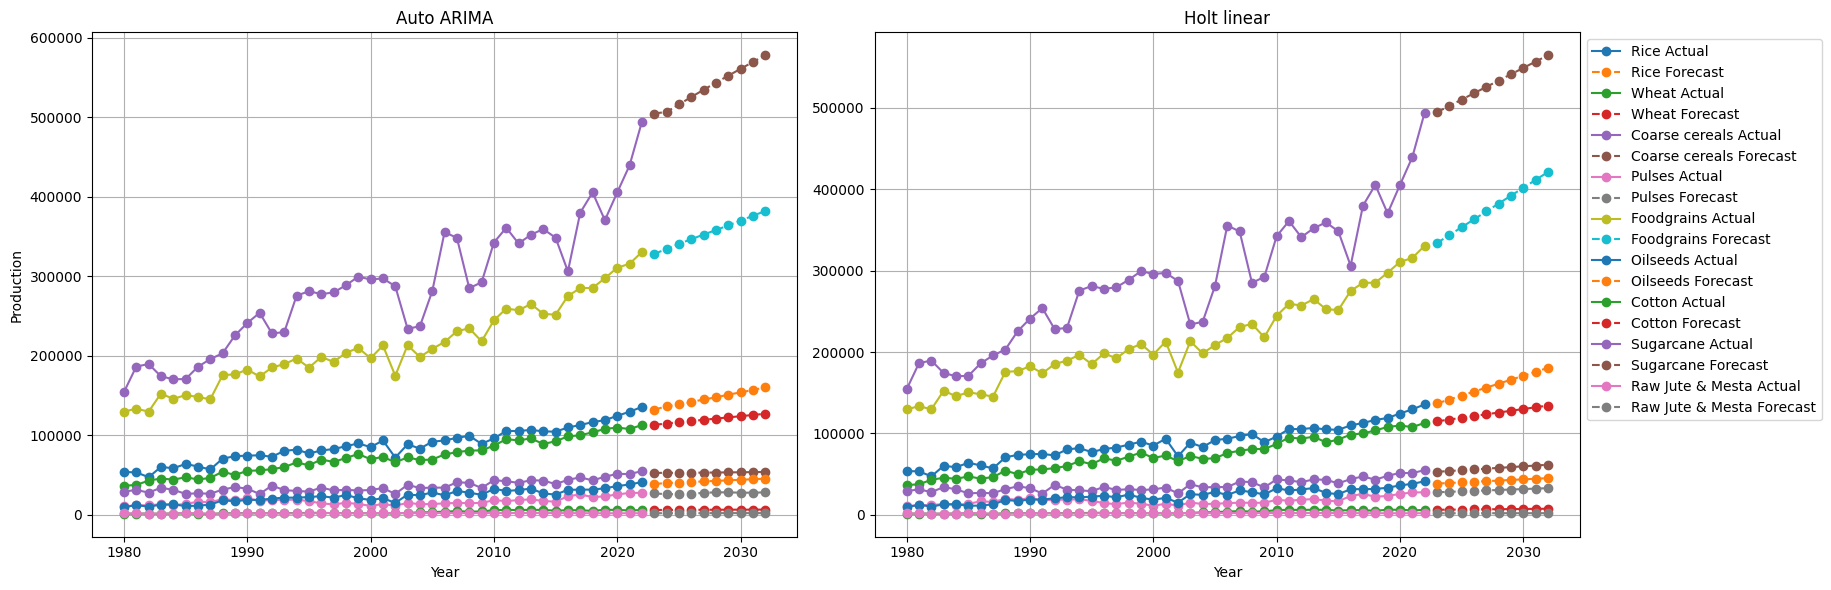

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
df_all_india = all_india[all_india['State'] == 'All India']
forecast_dfs = [('Auto ARIMA', forecast_df), ('Holt linear', h_forecast_df)]

for i, (title, f_df) in enumerate(forecast_dfs, 1):
    plt.subplot(1, 2, i)
    for crop in df_all_india.columns[2:]:
        actual = df_all_india[['Year', crop]]
        forecast = (
            f_df[f_df['Crop'] == crop]
            .groupby('Year')['Forecast_Production']
            .sum()
            .reset_index()
        )
        plt.plot(actual['Year'], actual[crop], label=f"{crop} Actual", marker='o')
        plt.plot(forecast['Year'], forecast['Forecast_Production'], linestyle='--', label=f"{crop} Forecast", marker='o')
    plt.title(title)
    plt.xlabel("Year")
    if i == 1:
        plt.ylabel("Production")
    plt.grid(True)

plt.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()
